**Notebook A: HealthAI_Tabular**

1_data_preprocessing.ipynb → Synthetic data creation + saving

2_eda_feature_engineering.ipynb → EDA + feature engineering

3_classification.ipynb → Risk stratification (diabetes, heart disease etc.)

4_regression.ipynb → LOS prediction

5_clustering.ipynb → Patient segmentation

6_association_rules.ipynb → Medical associations (Apriori)

📌 Deliverables: CSVs, graphs, ML models (.joblib)

**1_data_preprocessing** → Synthetic data creation + saving

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Tabular Data Shapes → Train: (70000, 12) Val: (15000, 12) Test: (15000, 12)

🔹 Tabular Data Samples (Train set):
  admission_date  age  gender   BMI  systolic_bp  diastolic_bp  cholesterol  \
0     2015-01-01   72    Male  26.7          166           100          242   
1     2015-01-01   89  Female  27.5          100            61          235   
2     2015-01-01   71    Male  22.8          157            82          248   
3     2015-01-01   80  Female  23.2          110            65          258   
4     2015-01-01   80  Female   NaN          100            87          183   
5     2015-01-01   28  Female  37.4          115            61          240   
6     2015-01-01   41  Female  24.7          133           102          174   
7     2015-01-01   62    Male  21.1          155           101          296   
8     2015-01-01   20  Female  33.8          147            75          186   
9     2015-01-01   47  Female  28.5          128            98          287   

   glucose  hyper

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Saved tokenized text dataset → processed_data/text/synthetic_text.csv

🔹 Text Data Samples:
                                                note  \
0          Patient is recovering well after surgery.   
1            No major issues, routine check-up done.   
2  Shows signs of hypertension and requires medic...   
3          Complains of chest pain, ECG recommended.   
4          Patient is recovering well after surgery.   
5  Blood sugar levels are high, possible diabetes...   
6          Patient is recovering well after surgery.   
7            No major issues, routine check-up done.   
8  Blood sugar levels are high, possible diabetes...   
9          Complains of chest pain, ECG recommended.   

                                          feedback  
0  I am unhappy with the food quality in hospital.  
1       Waiting time was too long and frustrating.  
2            The overall experience was excellent.  
3  I am unhappy with the food quality in hospital.  
4           The nurses wer

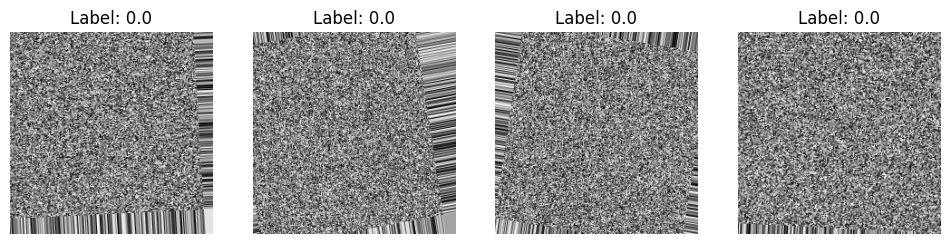

In [ ]:
# ===============================================
# 1_data_preprocessing.ipynb
# Synthetic Data Generation (75K+ Patients)
# Outputs saved + displayed for inspection
# ===============================================

import numpy as np
import pandas as pd
import random
import os
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import torch
from transformers import AutoTokenizer

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt

# Create output folders
os.makedirs("processed_data/tabular", exist_ok=True)
os.makedirs("processed_data/text", exist_ok=True)
os.makedirs("processed_data/images", exist_ok=True)

# ------------------------------------------------
# Part A: Synthetic Clinical Tabular Data
# ------------------------------------------------

np.random.seed(42)
N = 100000   # 1 lakh patients

# Generate admission dates over 5 years
start_date = datetime(2015, 1, 1)
admission_dates = [start_date + timedelta(days=int(x)) for x in np.random.randint(0, 365*5, N)]

ehr_df = pd.DataFrame({
    "admission_date": admission_dates,
    "age": np.random.randint(20, 90, N),
    "gender": np.random.choice(["Male", "Female"], N),
    "BMI": np.round(np.random.normal(27, 5, N), 1),
    "systolic_bp": np.random.randint(100, 180, N),
    "diastolic_bp": np.random.randint(60, 110, N),
    "cholesterol": np.random.randint(150, 300, N),
    "glucose": np.random.randint(70, 200, N),
    "hypertension": np.random.choice([0, 1], N),
    "diabetes": np.random.choice([0, 1], N),
    "length_of_stay": np.random.randint(1, 15, N)  # regression target
})

# Add some missing values
ehr_df.loc[ehr_df.sample(frac=0.05).index, "BMI"] = np.nan

# Preprocessing pipeline
numeric_features = ["age","BMI","systolic_bp","diastolic_bp","cholesterol","glucose"]
categorical_features = ["gender","hypertension","diabetes"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Chronological split
ehr_df = ehr_df.sort_values("admission_date").reset_index(drop=True)
train_size = int(0.7 * len(ehr_df))
val_size = int(0.15 * len(ehr_df))

train_df = ehr_df.iloc[:train_size]
val_df = ehr_df.iloc[train_size:train_size+val_size]
test_df = ehr_df.iloc[train_size+val_size:]

X_train = train_df.drop(columns=["length_of_stay","admission_date"])
y_train = train_df["length_of_stay"]
X_val = val_df.drop(columns=["length_of_stay","admission_date"])
y_val = val_df["length_of_stay"]
X_test = test_df.drop(columns=["length_of_stay","admission_date"])
y_test = test_df["length_of_stay"]

X_train_prep = preprocessor.fit_transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep = preprocessor.transform(X_test)

print("Tabular Data Shapes → Train:", X_train_prep.shape, "Val:", X_val_prep.shape, "Test:", X_test_prep.shape)

# Save outputs
train_df.to_csv("processed_data/tabular/train_ehr.csv", index=False)
val_df.to_csv("processed_data/tabular/val_ehr.csv", index=False)
test_df.to_csv("processed_data/tabular/test_ehr.csv", index=False)

# === SHOW TABULAR OUTPUTS ===
print("\n🔹 Tabular Data Samples (Train set):")
print(train_df.head(10))

print("\n📊 Tabular Data Summary (statistics):")
print(train_df.describe(include="all"))

# ------------------------------------------------
# Part B: Synthetic Clinical Text Data
# ------------------------------------------------

notes = [
    "Patient is recovering well after surgery.",
    "Shows signs of hypertension and requires medication.",
    "Blood sugar levels are high, possible diabetes risk.",
    "Complains of chest pain, ECG recommended.",
    "No major issues, routine check-up done."
]

feedback = [
    "The nurses were very kind and helpful.",
    "Waiting time was too long and frustrating.",
    "Doctor explained the treatment clearly.",
    "I am unhappy with the food quality in hospital.",
    "The overall experience was excellent."
]

N_text = 50000  # 50K synthetic text entries
synthetic_notes = [random.choice(notes) for _ in range(N_text)]
synthetic_feedback = [random.choice(feedback) for _ in range(N_text)]

text_df = pd.DataFrame({
    "note": synthetic_notes,
    "feedback": synthetic_feedback
})

# BioBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

text_df["note_tokens"] = text_df["note"].apply(lambda x: tokenizer.encode(x, truncation=True, padding="max_length", max_length=64))
text_df["feedback_tokens"] = text_df["feedback"].apply(lambda x: tokenizer.encode(x, truncation=True, padding="max_length", max_length=64))

# Save
text_df.to_csv("processed_data/text/synthetic_text.csv", index=False)
print("Saved tokenized text dataset → processed_data/text/synthetic_text.csv")

# === SHOW TEXT OUTPUTS ===
print("\n🔹 Text Data Samples:")
print(text_df[["note","feedback"]].head(10))

print("\n📝 Tokenized Example:")
print("Note Tokens:", text_df["note_tokens"].iloc[0][:20])
print("Feedback Tokens:", text_df["feedback_tokens"].iloc[0][:20])

# ------------------------------------------------
# Part C: Synthetic Imaging Data
# ------------------------------------------------

img_dir = "processed_data/images/xrays"
os.makedirs(img_dir, exist_ok=True)

num_images = 2000  # adjust if memory is tight
labels = []

for i in range(num_images):
    img_array = np.random.randint(0, 256, (256,256), dtype=np.uint8)
    label = random.choice(["Normal","Pneumonia"])
    labels.append(label)
    img = Image.fromarray(img_array)
    img.save(f"{img_dir}/xray_{i}_{label}.png")

print(f"Generated {num_images} synthetic chest X-ray images → {img_dir}")

# Image preprocessing pipeline (resize + augment)
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    "processed_data/images/",
    target_size=(224,224),
    color_mode="grayscale",
    batch_size=32,
    class_mode="binary",
    subset="training",
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    "processed_data/images/",
    target_size=(224,224),
    color_mode="grayscale",
    batch_size=32,
    class_mode="binary",
    subset="validation",
    shuffle=False
)

print("✅ Image preprocessing pipeline ready.")

# === SHOW IMAGE OUTPUTS ===
print("\n🔹 First 10 Image Files:")
for i in range(10):
    print(f"xray_{i}_{labels[i]}.png → Label: {labels[i]}")

# Visualize a few augmented images
x_batch, y_batch = next(train_gen)
fig, axes = plt.subplots(1,4, figsize=(12,3))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_batch[i].squeeze(), cmap="gray")
    ax.set_title(f"Label: {y_batch[i]}")
    ax.axis("off")
plt.show()

**2.EDA + Feature Engineering** → EDA + feature engineering

Data shape: (70000, 11)


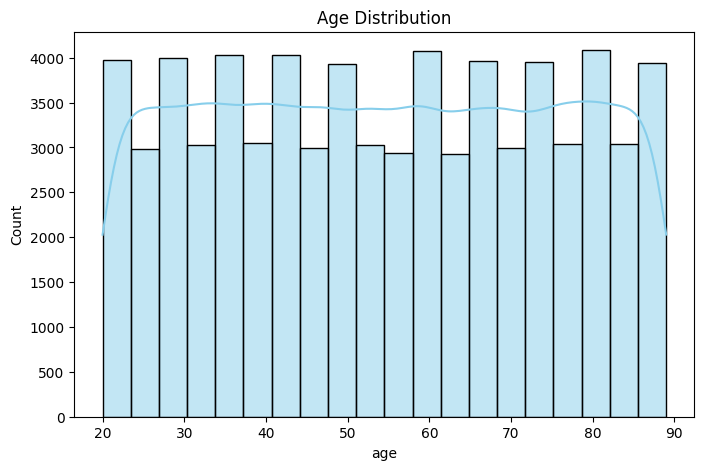

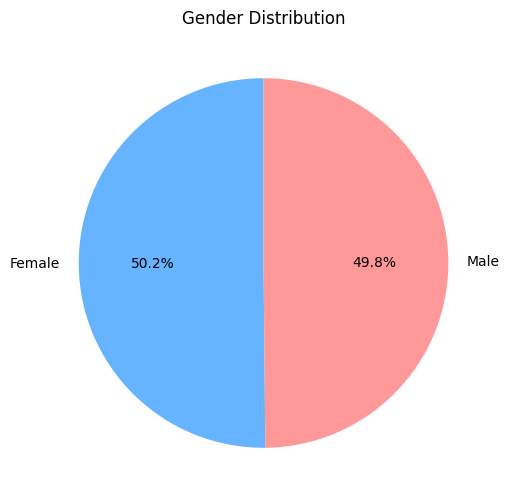

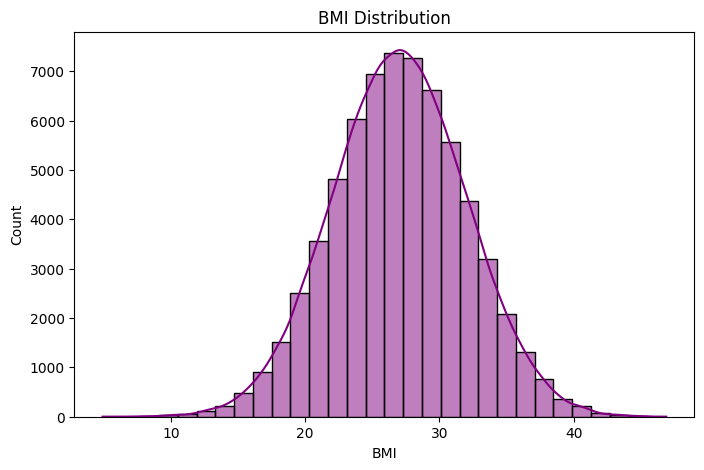

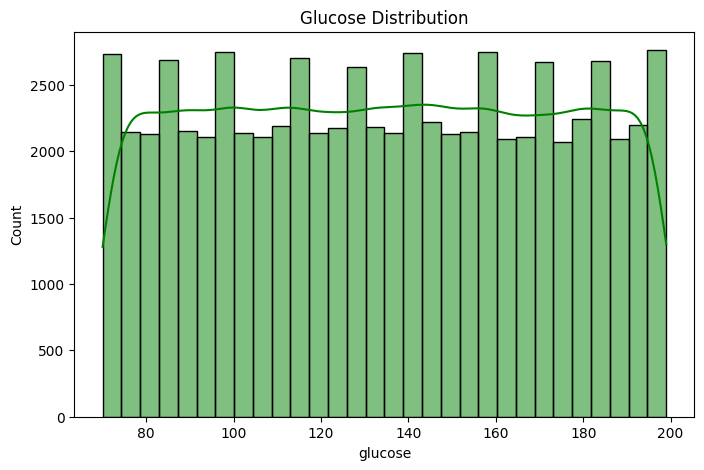

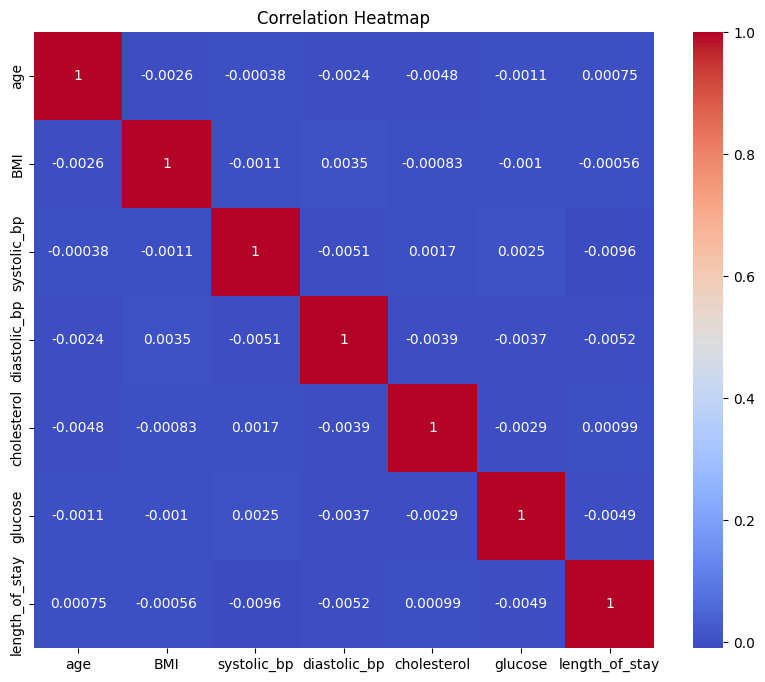

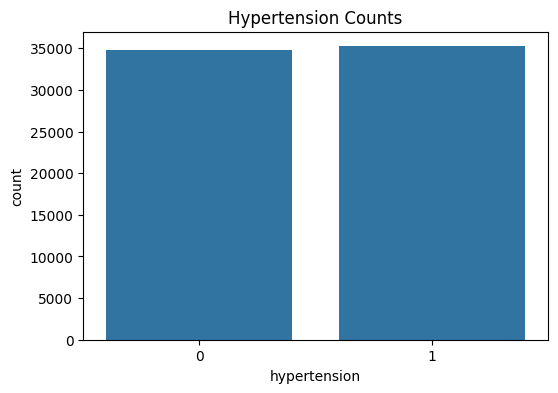

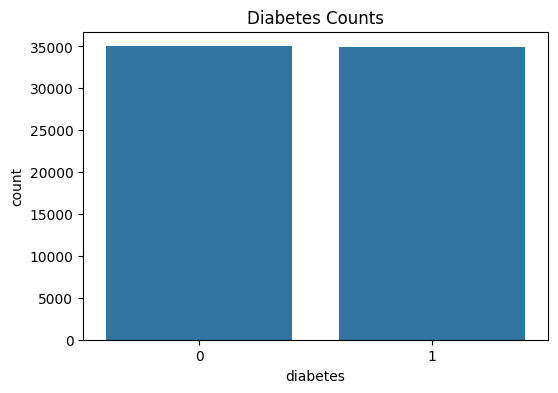


🔹 Sample rows with engineered features:
   age   BMI  systolic_bp  diastolic_bp       bp_category  cholesterol  \
0   72  26.7          166           100      Hypertension          242   
1   89  27.5          100            61            Normal          235   
2   71  22.8          157            82  Pre-Hypertension          248   
3   80  23.2          110            65            Normal          258   
4   80   NaN          100            87  Pre-Hypertension          183   
5   28  37.4          115            61            Normal          240   
6   41  24.7          133           102  Pre-Hypertension          174   
7   62  21.1          155           101      Hypertension          296   
8   20  33.8          147            75      Hypertension          186   
9   47  28.5          128            98  Pre-Hypertension          287   

    chol_risk  
0        High  
1  Borderline  
2        High  
3        High  
4      Normal  
5  Borderline  
6      Normal  
7        High  


In [ ]:
# ===============================================
# EDA + Feature Engineering (on Tabular Data)
# ===============================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load train dataset
train_df = pd.read_csv("processed_data/tabular/train_ehr.csv", parse_dates=["admission_date"])
print("Data shape:", train_df.shape)

# ----------------------------
# EDA: Demographics
# ----------------------------
plt.figure(figsize=(8,5))
sns.histplot(train_df["age"], bins=20, kde=True, color="skyblue")
plt.title("Age Distribution")
plt.show()

plt.figure(figsize=(6,6))
train_df["gender"].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=["#66b3ff","#ff9999"])
plt.title("Gender Distribution")
plt.ylabel("")
plt.show()

# ----------------------------
# EDA: Clinical Indicators
# ----------------------------
plt.figure(figsize=(8,5))
sns.histplot(train_df["BMI"], bins=30, kde=True, color="purple")
plt.title("BMI Distribution")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(train_df["glucose"], bins=30, kde=True, color="green")
plt.title("Glucose Distribution")
plt.show()

plt.figure(figsize=(10,8))
corr = train_df[["age","BMI","systolic_bp","diastolic_bp","cholesterol","glucose","length_of_stay"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(data=train_df, x="hypertension")
plt.title("Hypertension Counts")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(data=train_df, x="diabetes")
plt.title("Diabetes Counts")
plt.show()

# ----------------------------
# Feature Engineering
# ----------------------------
def bp_category(row):
    if row["systolic_bp"] < 120 and row["diastolic_bp"] < 80:
        return "Normal"
    elif 120 <= row["systolic_bp"] < 140 or 80 <= row["diastolic_bp"] < 90:
        return "Pre-Hypertension"
    else:
        return "Hypertension"

train_df["bp_category"] = train_df.apply(bp_category, axis=1)
train_df["chol_risk"] = pd.cut(train_df["cholesterol"], bins=[0,200,240,400], labels=["Normal","Borderline","High"])

print("\n🔹 Sample rows with engineered features:")
print(train_df[["age","BMI","systolic_bp","diastolic_bp","bp_category","cholesterol","chol_risk"]].head(10))

**3.Classification – Risk Stratification**

In [ ]:
# ===============================================
# Risk Stratification: Diabetes, Heart, Cancer
# Fixed: No SettingWithCopyWarning + Improved Cancer Risk Rule
# ===============================================

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# ----------------------------
# 1. Define synthetic risk labels
# ----------------------------
def make_diabetes_risk(df):
    return ((df["glucose"] > 140) | (df["BMI"] >= 30) | ((df["glucose"] > 120) & (df["hypertension"]==1))).astype(int)

def make_heart_risk(df):
    return ((df["cholesterol"] > 240) & (df["systolic_bp"] > 140) & (df["age"] > 50)).astype(int)

def make_cancer_risk(df):
    return (
        ((df["age"] > 55) & (df["length_of_stay"] > 7)) |
        ((df["cholesterol"] > 250) & (df["BMI"] > 28)) |
        ((df["glucose"] > 160) & (df["hypertension"] == 1))
    ).astype(int)

for dataset in [train_df, val_df, test_df]:
    dataset.loc[:, "diabetes_risk"] = make_diabetes_risk(dataset)
    dataset.loc[:, "heart_risk"]    = make_heart_risk(dataset)
    dataset.loc[:, "cancer_risk"]   = make_cancer_risk(dataset)

# ----------------------------
# 2. Preprocessing
# ----------------------------
NUM_COLS = ["age","BMI","systolic_bp","diastolic_bp","cholesterol","glucose"]
CAT_COLS = ["gender","hypertension","diabetes"]

preprocessor = ColumnTransformer([
    ("num", Pipeline([("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]), NUM_COLS),
    ("cat", OneHotEncoder(handle_unknown="ignore"), CAT_COLS)
])

# ----------------------------
# 3. Train & Evaluate function
# ----------------------------
def train_and_eval(target_name):
    print("\n==============================")
    print(f" Risk Stratification → {target_name}")
    print("==============================")

    X_train, y_train = train_df[NUM_COLS+CAT_COLS], train_df[target_name]
    X_val,   y_val   = val_df[NUM_COLS+CAT_COLS],   val_df[target_name]

    X_train_proc = preprocessor.fit_transform(X_train)
    X_val_proc   = preprocessor.transform(X_val)

    sm = SMOTE(random_state=42)
    X_train_bal, y_train_bal = sm.fit_resample(X_train_proc, y_train)

    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
        "MLP (NN)": MLPClassifier(hidden_layer_sizes=(128,64), max_iter=30)
    }

    for name, model in models.items():
        model.fit(X_train_bal, y_train_bal)
        preds = model.predict(X_val_proc)
        probs = model.predict_proba(X_val_proc)[:,1]

        acc = accuracy_score(y_val, preds)
        f1  = f1_score(y_val, preds)
        roc = roc_auc_score(y_val, probs)

        print(f"{name} → Accuracy: {acc:.3f}, F1: {f1:.3f}, ROC-AUC: {roc:.3f}")
        print(classification_report(y_val, preds))

# ----------------------------
# 4. Run all 3 risk types
# ----------------------------
train_and_eval("diabetes_risk")
train_and_eval("heart_risk")
train_and_eval("cancer_risk")


 Risk Stratification → diabetes_risk
Logistic Regression → Accuracy: 0.880, F1: 0.904, ROC-AUC: 0.958
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      5190
           1       0.94      0.87      0.90      9810

    accuracy                           0.88     15000
   macro avg       0.86      0.88      0.87     15000
weighted avg       0.89      0.88      0.88     15000



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:54:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost → Accuracy: 1.000, F1: 1.000, ROC-AUC: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5190
           1       1.00      1.00      1.00      9810

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP (NN) → Accuracy: 0.998, F1: 0.998, ROC-AUC: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5190
           1       1.00      1.00      1.00      9810

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000


 Risk Stratification → heart_risk
Logistic Regression → Accuracy: 0.901, F1: 0.658, ROC-AUC: 0.970
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     13433
           1       0.51      0.91      0.66      1567

    accuracy                           0.90     15000
   macro avg       0.75      0.91      0.80     15000
weighted avg       0.94      0.90      0.91     15000



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:55:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost → Accuracy: 1.000, F1: 1.000, ROC-AUC: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13433
           1       1.00      1.00      1.00      1567

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP (NN) → Accuracy: 0.998, F1: 0.991, ROC-AUC: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13433
           1       0.99      0.99      0.99      1567

    accuracy                           1.00     15000
   macro avg       1.00      0.99      0.99     15000
weighted avg       1.00      1.00      1.00     15000


 Risk Stratification → cancer_risk
Logistic Regression → Accuracy: 0.720, F1: 0.690, ROC-AUC: 0.802
              precision    recall  f1-score   support

           0       0.77      0.72      0.74      8496
           1       0.66      0.72      0.69      6504

    accuracy                           0.72     15000
   macro avg       0.72      0.72      0.72     15000
weighted avg       0.72      0.72      0.72     15000



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:56:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost → Accuracy: 0.818, F1: 0.801, ROC-AUC: 0.933
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      8496
           1       0.76      0.85      0.80      6504

    accuracy                           0.82     15000
   macro avg       0.82      0.82      0.82     15000
weighted avg       0.82      0.82      0.82     15000

MLP (NN) → Accuracy: 0.817, F1: 0.806, ROC-AUC: 0.932
              precision    recall  f1-score   support

           0       0.89      0.77      0.83      8496
           1       0.74      0.88      0.81      6504

    accuracy                           0.82     15000
   macro avg       0.82      0.82      0.82     15000
weighted avg       0.83      0.82      0.82     15000



/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


**4.Regression: Length of Stay Prediction**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded shapes: (70000, 11) (15000, 11) (15000, 11)
Processed shapes: (70000, 12) (15000, 12) (15000, 12)

Baseline (mean) on validation → MAE: 3.499, RMSE: 4.036, R2: -0.000

Training LinearRegression ...
LinearRegression → MAE: 3.499, RMSE: 4.037, R2: -0.001

Training RandomForest ...
RandomForest → MAE: 3.524, RMSE: 4.089, R2: -0.027

Training XGBoost ...
XGBoost → MAE: 3.527, RMSE: 4.099, R2: -0.032

Training MLP ...
MLP → MAE: 3.506, RMSE: 4.065, R2: -0.015

Best classical regressor on validation: LinearRegression {'model': LinearRegression(), 'mae': 3.499287706321161, 'rmse': np.float64(4.036628459394296), 'r2': -0.0007946606438056225}

Test metrics for LinearRegression → MAE: 3.496, RMSE: 4.026, R2: -0.001
Saved best classical model and preprocessor to Drive.


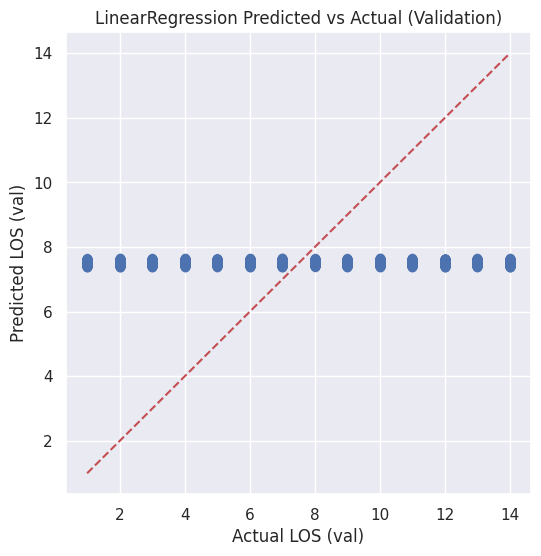

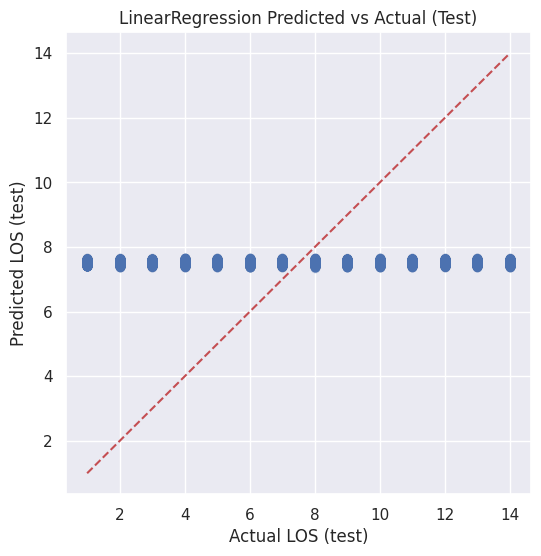


Building LSTM dataset (N=5000, timesteps=12) ...
Any NaNs? False False False
Any Infinities? False False False
Epoch 1/8
47/47 - 3s - 65ms/step - loss: 46.8400 - mae: 5.6904 - val_loss: 20.1112 - val_mae: 3.8219
Epoch 2/8
47/47 - 1s - 20ms/step - loss: 17.1139 - mae: 3.5297 - val_loss: 16.7892 - val_mae: 3.5735
Epoch 3/8
47/47 - 1s - 12ms/step - loss: 16.5607 - mae: 3.4894 - val_loss: 16.7813 - val_mae: 3.5776
Epoch 4/8
47/47 - 1s - 11ms/step - loss: 16.4643 - mae: 3.4781 - val_loss: 16.7895 - val_mae: 3.5774
Epoch 5/8
47/47 - 1s - 12ms/step - loss: 16.4916 - mae: 3.4794 - val_loss: 16.8162 - val_mae: 3.5816
Epoch 6/8
47/47 - 1s - 11ms/step - loss: 16.4219 - mae: 3.4807 - val_loss: 16.7776 - val_mae: 3.5797
Epoch 7/8
47/47 - 1s - 13ms/step - loss: 16.3710 - mae: 3.4739 - val_loss: 16.8314 - val_mae: 3.5842
Epoch 8/8
47/47 - 1s - 11ms/step - loss: 16.3345 - mae: 3.4681 - val_loss: 16.8015 - val_mae: 3.5835
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

LSTM Test → MAE: 3.561, RMSE: 4.073, R2:

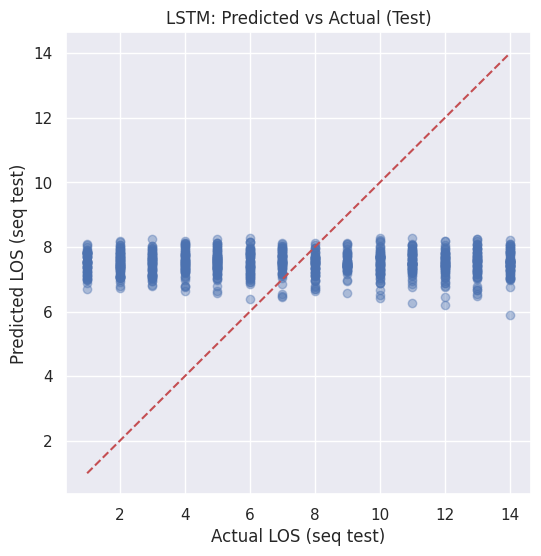

In [ ]:
# ============================
# Regression: Length of Stay Prediction (single cell)
# - Tabular regressors: Linear, RandomForest, XGBoost, MLP
# - Sequence regressor: LSTM on synthetic vitals sequences (small subset)
# - Metrics: RMSE, MAE, R2
# - Plots: Predicted vs Actual
# - Saves best models to Drive
# ============================

# Install optional packages (uncomment if needed)
# !pip install -q xgboost tensorflow==2.12.0

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

import joblib
import warnings
warnings.filterwarnings("ignore")

# ----------------------
# 0. Mount Drive & paths
# ----------------------
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = "/content/drive/MyDrive/HealthAI_Project/processed_data/tabular"
MODEL_PATH = "/content/drive/MyDrive/HealthAI_Project/models"
os.makedirs(MODEL_PATH, exist_ok=True)

train_csv = os.path.join(BASE_PATH, "train_ehr.csv")
val_csv   = os.path.join(BASE_PATH, "val_ehr.csv")
test_csv  = os.path.join(BASE_PATH, "test_ehr.csv")
assert os.path.exists(train_csv), f"{train_csv} not found. Run preprocessing and save files to Drive."

# ----------------------
# 1. Load Data
# ----------------------
train_df = pd.read_csv(train_csv, parse_dates=["admission_date"])
val_df   = pd.read_csv(val_csv, parse_dates=["admission_date"])
test_df  = pd.read_csv(test_csv, parse_dates=["admission_date"])

print("Loaded shapes:", train_df.shape, val_df.shape, test_df.shape)

# ----------------------
# 2. Feature selection and preprocessing pipeline
# ----------------------
NUM_COLS = ["age","BMI","systolic_bp","diastolic_bp","cholesterol","glucose"]
CAT_COLS = ["gender","hypertension","diabetes"]

# Keep LOS as target
y_train = train_df["length_of_stay"].values
y_val   = val_df["length_of_stay"].values
y_test  = test_df["length_of_stay"].values

X_train = train_df[NUM_COLS + CAT_COLS].copy()
X_val   = val_df[NUM_COLS + CAT_COLS].copy()
X_test  = test_df[NUM_COLS + CAT_COLS].copy()

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

# Fix for sklearn >=1.2
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, NUM_COLS),
    ("cat", categorical_transformer, CAT_COLS)
])

# Fit & transform
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc   = preprocessor.transform(X_val)
X_test_proc  = preprocessor.transform(X_test)

print("Processed shapes:", X_train_proc.shape, X_val_proc.shape, X_test_proc.shape)

# ----------------------
# 3. Baseline: predict mean LOS from train
# ----------------------
baseline_pred = np.full_like(y_val, fill_value=y_train.mean(), dtype=float)
baseline_mae = mean_absolute_error(y_val, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_val, baseline_pred))
baseline_r2 = r2_score(y_val, baseline_pred)
print("\nBaseline (mean) on validation → MAE: {:.3f}, RMSE: {:.3f}, R2: {:.3f}".format(baseline_mae, baseline_rmse, baseline_r2))

# ----------------------
# 4. Train classical regressors
# ----------------------
regressors = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, n_jobs=2),
    "MLP": MLPRegressor(hidden_layer_sizes=(128,64), max_iter=100, random_state=42)
}

results = {}
for name, model in regressors.items():
    print(f"\nTraining {name} ...")
    model.fit(X_train_proc, y_train)
    preds_val = model.predict(X_val_proc)
    mae = mean_absolute_error(y_val, preds_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds_val))
    r2 = r2_score(y_val, preds_val)
    results[name] = {"model": model, "mae": mae, "rmse": rmse, "r2": r2}
    print(f"{name} → MAE: {mae:.3f}, RMSE: {rmse:.3f}, R2: {r2:.3f}")

# ----------------------
# 5. Select best classical model by MAE (lower is better)
# ----------------------
best_name = min(results.keys(), key=lambda k: results[k]["mae"])
best_model = results[best_name]["model"]
print("\nBest classical regressor on validation:", best_name, results[best_name])

# Evaluate best on test set
preds_test = best_model.predict(X_test_proc)
mae_test = mean_absolute_error(y_test, preds_test)
rmse_test = np.sqrt(mean_squared_error(y_test, preds_test))
r2_test = r2_score(y_test, preds_test)
print(f"\nTest metrics for {best_name} → MAE: {mae_test:.3f}, RMSE: {rmse_test:.3f}, R2: {r2_test:.3f}")

# Save best classical model + preprocessor
joblib.dump(best_model, os.path.join(MODEL_PATH, f"best_regressor_{best_name}.joblib"))
joblib.dump(preprocessor, os.path.join(MODEL_PATH, "preprocessor_regression.joblib"))
print("Saved best classical model and preprocessor to Drive.")

# ----------------------
# 6. Plot Predicted vs Actual (validation and test)
# ----------------------
plt.figure(figsize=(6,6))
plt.scatter(y_val, best_model.predict(X_val_proc), alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], "r--")
plt.xlabel("Actual LOS (val)")
plt.ylabel("Predicted LOS (val)")
plt.title(f"{best_name} Predicted vs Actual (Validation)")
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_test, preds_test, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual LOS (test)")
plt.ylabel("Predicted LOS (test)")
plt.title(f"{best_name} Predicted vs Actual (Test)")
plt.show()

# ----------------------
# 7. LSTM (sequence model) demonstration (fixed to avoid NaNs)
# ----------------------
run_lstm = True  # set False if you want to skip
if run_lstm:
    N_seq = min(5000, len(train_df))   # number of patients
    timesteps = 12
    seq_features = ["systolic_bp","diastolic_bp","glucose","BMI"]
    print(f"\nBuilding LSTM dataset (N={N_seq}, timesteps={timesteps}) ...")

    def build_sequences(df, n_samples, timesteps, features):
        rows = df.sample(n=n_samples, random_state=42).reset_index(drop=True)
        X_seq = np.zeros((n_samples, timesteps, len(features)), dtype=np.float32)
        y_seq = rows["length_of_stay"].values.astype(np.float32)
        for i in range(n_samples):
            # Handle potential NaNs in base values before adding noise/trend
            base = rows.loc[i, features].fillna(rows[features].mean()).values.astype(float)
            for t in range(timesteps):
                noise = np.random.normal(0, 0.05, size=base.shape)
                # Ensure trend calculation does not introduce NaNs or infinities
                trend = np.nan_to_num((t / timesteps) * (0.005 * base))
                X_seq[i, t, :] = base + trend + noise
        return X_seq, y_seq

    Xs_train, ys_train = build_sequences(train_df, min(3000, N_seq), timesteps, seq_features)
    Xs_val, ys_val     = build_sequences(val_df, min(1000, N_seq//3), timesteps, seq_features)
    Xs_test, ys_test   = build_sequences(test_df, min(1000, N_seq//3), timesteps, seq_features)

    # Standardize safely using a pipeline with imputer
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import StandardScaler

    scaler_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # Impute NaNs if any exist after sequence building
        ('scaler', StandardScaler())
    ])

    def scale_seq(X, scaler):
        shp = X.shape
        X_flat = X.reshape(-1, shp[2])
        Xs = scaler.transform(X_flat).reshape(shp)
        # clip to avoid exploding values
        Xs = np.clip(Xs, -10, 10)
        return Xs

    # Fit scaler on training data and transform all sets
    Xs_train_flat = Xs_train.reshape(-1, len(seq_features))
    scaler_pipeline.fit(Xs_train_flat)

    Xs_train_s = scale_seq(Xs_train, scaler_pipeline)
    Xs_val_s = scale_seq(Xs_val, scaler_pipeline)
    Xs_test_s = scale_seq(Xs_test, scaler_pipeline)

    print("Any NaNs?", np.isnan(Xs_train_s).any(), np.isnan(Xs_val_s).any(), np.isnan(Xs_test_s).any())
    print("Any Infinities?", np.isinf(Xs_train_s).any(), np.isinf(Xs_val_s).any(), np.isinf(Xs_test_s).any())


    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    tf.keras.utils.set_random_seed(42)

    model_lstm = Sequential([
        LSTM(64, input_shape=(timesteps, len(seq_features)), return_sequences=False),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dense(1)
    ])
    model_lstm.compile(optimizer="adam", loss="mse", metrics=["mae"])

    history = model_lstm.fit(
        Xs_train_s, ys_train,
        validation_data=(Xs_val_s, ys_val),
        epochs=8, batch_size=64, verbose=2
    )

    preds_lstm = model_lstm.predict(Xs_test_s).squeeze()

    mae_lstm = mean_absolute_error(ys_test, preds_lstm)
    rmse_lstm = np.sqrt(mean_squared_error(ys_test, preds_lstm))
    r2_lstm = r2_score(ys_test, preds_lstm)
    print(f"\nLSTM Test → MAE: {mae_lstm:.3f}, RMSE: {rmse_lstm:.3f}, R2: {r2_lstm:.3f}")

    plt.figure(figsize=(6,6))
    plt.scatter(ys_test, preds_lstm, alpha=0.4)
    plt.plot([ys_test.min(), ys_test.max()], [ys_test.min(), ys_test.max()], "r--")
    plt.xlabel("Actual LOS (seq test)")
    plt.ylabel("Predicted LOS (seq test)")
    plt.title("LSTM: Predicted vs Actual (Test)")
    plt.show()

**5.clustering → Patient segmentation**

Train shape: (70000, 11)

KMeans Results (k=3):
Silhouette Score: 0.112
Calinski-Harabasz: 8838.129

Silhouette scores for different K values:
KMeans with 2 clusters → Silhouette: 0.125
KMeans with 3 clusters → Silhouette: 0.112
KMeans with 4 clusters → Silhouette: 0.116
KMeans with 5 clusters → Silhouette: 0.117
KMeans with 2 clusters → Silhouette: 0.125
KMeans with 3 clusters → Silhouette: 0.112
KMeans with 4 clusters → Silhouette: 0.116
KMeans with 5 clusters → Silhouette: 0.117
KMeans with 6 clusters → Silhouette: 0.121
KMeans with 7 clusters → Silhouette: 0.122
KMeans with 8 clusters → Silhouette: 0.123
KMeans with 9 clusters → Silhouette: 0.126


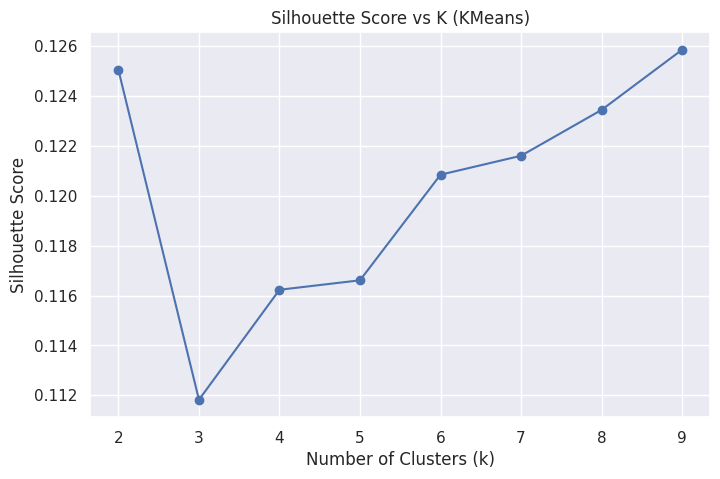


HDBSCAN Results:
Silhouette Score: None
Calinski-Harabasz: None


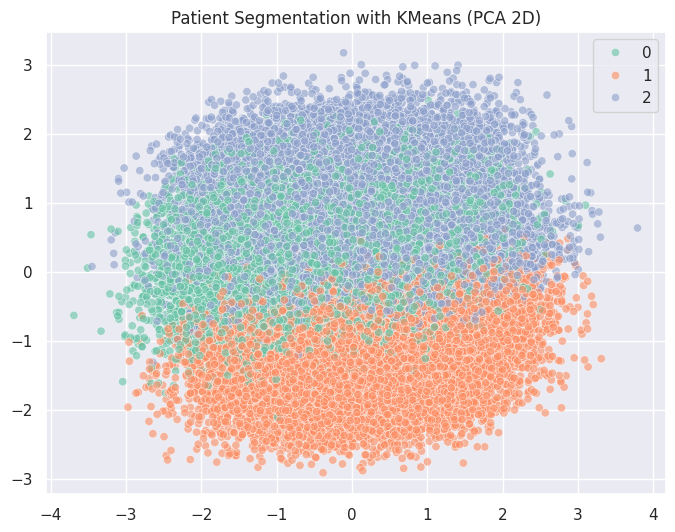

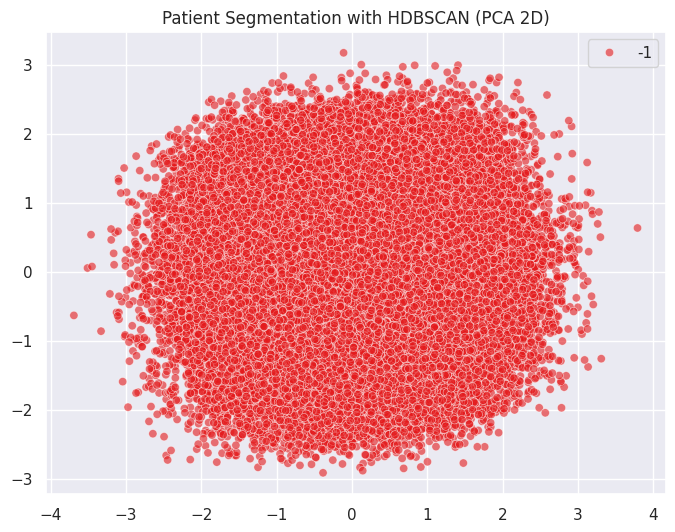


Cluster Profiles (KMeans):
                  age        BMI  systolic_bp  diastolic_bp  cholesterol  \
cluster_km                                                                 
0           67.569542  26.790447   139.571867     84.705650   264.820693   
1           67.244946  27.135087   138.741896     84.486614   183.975779   
2           33.337228  27.077309   139.424221     84.431118   225.221175   

               glucose  hypertension  diabetes  count  
cluster_km                                             
0           133.047942      0.504487  0.501186  21505  
1           135.592105      0.503233  0.501502  21964  
2           134.868682      0.502582  0.497456  26531  


In [ ]:
# ================================================
# Patient Segmentation (Clustering)
# ================================================

!pip install -q hdbscan

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import hdbscan
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# ----------------------------
# Load Data
# ----------------------------
BASE_PATH = "/content/drive/MyDrive/HealthAI_Project/processed_data/tabular"
train_df = pd.read_csv(f"{BASE_PATH}/train_ehr.csv", parse_dates=["admission_date"])
print("Train shape:", train_df.shape)

# ----------------------------
# Select features and preprocess
# ----------------------------
features = ["age","BMI","systolic_bp","diastolic_bp","cholesterol","glucose"]
X = train_df[features].copy()

# Create a pipeline for imputation and scaling
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

X_scaled = preprocessing_pipeline.fit_transform(X)

# ----------------------------
# KMeans (baseline with k=3)
# ----------------------------
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)  # baseline 3 clusters
labels_km = kmeans.fit_predict(X_scaled)

sil_km = silhouette_score(X_scaled, labels_km)
ch_km  = calinski_harabasz_score(X_scaled, labels_km)

print("\nKMeans Results (k=3):")
print("Silhouette Score:", round(sil_km,3))
print("Calinski-Harabasz:", round(ch_km,3))
train_df["cluster_km"] = labels_km

# ----------------------------
# Test multiple K values (2–5)
# ----------------------------
print("\nSilhouette scores for different K values:")
for k in range(2, 6):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    print(f"KMeans with {k} clusters → Silhouette: {sil:.3f}")

# ----------------------------
# Silhouette vs K (Elbow-like plot)
# ----------------------------
sil_scores = []
K_range = range(2, 10)  # test K from 2 to 9

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)
    print(f"KMeans with {k} clusters → Silhouette: {sil:.3f}")

# Plot
plt.figure(figsize=(8,5))
plt.plot(K_range, sil_scores, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs K (KMeans)")
plt.grid(True)
plt.show()


# ----------------------------
# HDBSCAN
# ----------------------------
clusterer = hdbscan.HDBSCAN(min_cluster_size=500, min_samples=20)
labels_hdb = clusterer.fit_predict(X_scaled)

if len(set(labels_hdb)) > 1:
    sil_hdb = silhouette_score(X_scaled, labels_hdb)
    ch_hdb  = calinski_harabasz_score(X_scaled, labels_hdb)
else:
    sil_hdb, ch_hdb = None, None

print("\nHDBSCAN Results:")
print("Silhouette Score:", sil_hdb)
print("Calinski-Harabasz:", ch_hdb)
train_df["cluster_hdb"] = labels_hdb

# ----------------------------
# Visualization
# ----------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_km, palette="Set2", alpha=0.6)
plt.title("Patient Segmentation with KMeans (PCA 2D)")
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_hdb, palette="Set1", alpha=0.6)
plt.title("Patient Segmentation with HDBSCAN (PCA 2D)")
plt.show()

# ----------------------------
# Clinical Interpretability
# ----------------------------
summary = train_df.groupby("cluster_km")[features+["hypertension","diabetes"]].mean()
summary["count"] = train_df.groupby("cluster_km").size()
print("\nCluster Profiles (KMeans):")
print(summary)

**6.Association_rules → Medical associations (Apriori)**

In [ ]:
# ================================================
# Medical Associations (Apriori)
# ================================================
!pip install -q mlxtend

import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import os # Import os module
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# ----------------------------
# Load Data
# ----------------------------
BASE_PATH = "/content/drive/MyDrive/HealthAI_Project/processed_data/tabular"
train_df = pd.read_csv(f"{BASE_PATH}/train_ehr.csv", parse_dates=["admission_date"])
print("Train shape:", train_df.shape)

# ----------------------------
# Create Boolean Features for Associations
# ----------------------------
assoc_df = pd.DataFrame({
    "high_BMI":       (train_df["BMI"] >= 30).astype(int),
    "hypertension":   train_df["hypertension"],
    "diabetes":       train_df["diabetes"],
    "high_glucose":   (train_df["glucose"] >= 140).astype(int),
    "high_chol":      (train_df["cholesterol"] >= 240).astype(int),
    "old_age":        (train_df["age"] >= 60).astype(int)
})

print("\nSample of transactional-like data:")
print(assoc_df.head())

# ----------------------------
# Run Apriori
# ----------------------------
freq_items = apriori(assoc_df.astype(bool), min_support=0.1, use_colnames=True)
print("\nFrequent Itemsets (top 10):")
print(freq_items.sort_values("support", ascending=False).head(10))

# ----------------------------
# Generate Association Rules
# ----------------------------
rules = association_rules(freq_items, metric="lift", min_threshold=1.0)
rules_sorted = rules.sort_values("lift", ascending=False)

print("\nTop 10 Association Rules:")
print(rules_sorted[["antecedents","consequents","support","confidence","lift"]].head(10))

# ----------------------------
# Save Results
# ----------------------------
OUTPUT_DIR = "/content/drive/MyDrive/HealthAI_Project/outputs" # Define output directory
os.makedirs(OUTPUT_DIR, exist_ok=True) # Create the directory if it doesn't exist
rules_sorted.to_csv(os.path.join(OUTPUT_DIR, "association_rules.csv"), index=False) # Use os.path.join for path
print(f"\n✅ Rules saved to {os.path.join(OUTPUT_DIR, 'association_rules.csv')}")

Train shape: (70000, 11)

Sample of transactional-like data:
   high_BMI  hypertension  diabetes  high_glucose  high_chol  old_age
0         0             0         1             0          1        1
1         0             1         1             1          0        1
2         0             1         1             0          1        1
3         0             1         1             1          1        1
4         0             1         1             1          0        1

Frequent Itemsets (top 10):
     support                      itemsets
1   0.503371                (hypertension)
2   0.499871                    (diabetes)
3   0.461957                (high_glucose)
5   0.427771                     (old_age)
4   0.400429                   (high_chol)
0   0.263629                    (high_BMI)
11  0.250743      (diabetes, hypertension)
12  0.233586  (hypertension, high_glucose)
15  0.230429      (diabetes, high_glucose)
14  0.216143       (hypertension, old_age)

Top 10 Associati

In [ ]:
# ==================================================
# Backup synthetic data outputs to Google Drive
# ==================================================
from google.colab import drive
import shutil
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define source (current Colab session) and destination (Drive)
SRC = "/content/processed_data"
DST = "/content/drive/MyDrive/HealthAI_Project/processed_data"

# Copy everything to Drive
if os.path.exists(SRC):
    shutil.copytree(SRC, DST, dirs_exist_ok=True)
    print(f"✅ All synthetic data saved permanently in: {DST}")
else:
    print("⚠️ No 'processed_data' folder found in session. Did you run preprocessing?")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ All synthetic data saved permanently in: /content/drive/MyDrive/HealthAI_Project/processed_data
